In [1]:
import os
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torchvision
from torch.utils.data import DataLoader, Dataset, random_split
import torchvision.transforms as transforms

#For converting the dataset to torchvision dataset format
class VowelConsonantDataset(Dataset):
    def __init__(self, file_path,train=True,transform=None):
        self.transform = transform
        self.file_path=file_path
        self.train=train
        self.file_names=[file for _,_,files in os.walk(self.file_path) for file in files]
        self.len = len(self.file_names)
        if self.train:
            self.classes_mapping=self.get_classes()
    def __len__(self):
        return len(self.file_names)
    
    def __getitem__(self, index):
        file_name=self.file_names[index]
        image_data=self.pil_loader(self.file_path+"/"+file_name)
        if self.transform:
            image_data = self.transform(image_data)
        if self.train:
            file_name_splitted=file_name.split("_")
            Y1 = self.classes_mapping[file_name_splitted[0]]
            Y2 = self.classes_mapping[file_name_splitted[1]]
            z1,z2=torch.zeros(10),torch.zeros(10)
            z1[Y1-10],z2[Y2]=1,1
            label=torch.stack([z1,z2])

            return image_data, label

        else:
            return image_data, file_name
          
    def pil_loader(self,path):
        with open(path, 'rb') as f:
            img = Image.open(f)
            return img.convert('RGB')

      
    def get_classes(self):
        classes=[]
        for name in self.file_names:
            name_splitted=name.split("_")
            classes.extend([name_splitted[0],name_splitted[1]])
        classes=list(set(classes))
        classes_mapping={}
        for i,cl in enumerate(sorted(classes)):
            classes_mapping[cl]=i
        return classes_mapping
    

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import matplotlib.pyplot as plt
from torchvision import datasets

import torchvision.transforms as transforms

import numpy as np
import pandas as pd

train_on_gpu = torch.cuda.is_available()
device='cuda:0'

In [3]:
transform = transforms.Compose([
    transforms.RandomResizedCrop(224), 
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
   ])

In [4]:
full_data = VowelConsonantDataset("../input/train/train",train=True,transform=transform)
train_size = int(0.9 * len(full_data))
test_size = len(full_data) - train_size

train_data, validation_data = random_split(full_data, [train_size, test_size])

train_loader = torch.utils.data.DataLoader(train_data, batch_size=4, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_data, batch_size=4, shuffle=True)

In [5]:
test_data = VowelConsonantDataset("../input/test/test",train=False,transform=transform)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=4,shuffle=False)

In [6]:
dataiter=iter(train_loader)
images,labels= dataiter.next()
print(labels[0])

tensor([[0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]])


In [7]:
img=images[1].numpy()
img=np.transpose(img,(1,2,0))
print(img.shape)

(224, 224, 3)


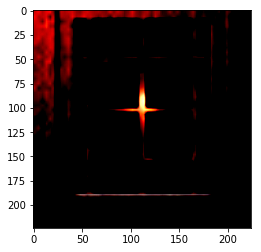

In [8]:
plt.imshow(img)

In [9]:
from torchvision import models
vgg = models.vgg16_bn(pretrained=True)

Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /tmp/.cache/torch/checkpoints/vgg16_bn-6c64b313.pth
100%|██████████| 553507836/553507836 [00:13<00:00, 39906688.28it/s]


In [10]:
for param in vgg.parameters():
    param.requires_grad = False

In [11]:
final_in_features = vgg.classifier[6].in_features
mod_classifier = list(vgg.classifier.children())[:-1]
vgg.classifier = nn.Sequential(*mod_classifier)

In [12]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.model = vgg
        self.vowel = nn.Sequential(nn.Linear(final_in_features, 10),nn.LogSoftmax(dim = 1))
        self.cons = nn.Sequential(nn.Linear(final_in_features, 10),nn.LogSoftmax(dim = 1))
        
        
        
        
      

    def forward(self, x):
        x=self.model.features(x)
        x=x.view(x.size(0),-1)
        x=self.model.classifier(x)
        v=self.vowel(x)
        c=self.cons(x)
        
        return v,c


In [13]:
vgg = vgg.to(device)
loss_fn = nn.CrossEntropyLoss()
opt = optim.SGD(vgg.parameters(), lr=0.05)

In [14]:
net=Model()

In [15]:
device='cuda:0'

In [16]:
net=net.to(device)

In [17]:
import copy

In [18]:
loss_epoch_arr = []
max_epochs = 1

min_loss = 1000

n_iters = np.ceil(50000/4)

for epoch in range(max_epochs):

    for i, data in enumerate(train_loader, 0):

        inputs,labels=data
        inputs=inputs.to(device)
        labels1,labels2=labels[:,0],labels[:,1]
        targetnp=labels1.cpu().numpy()
        targetnp1 = labels2.cpu().numpy()
        l1=np.where(targetnp>0)[1]
        l2=np.where(targetnp1>0)[1]
        new_targets=torch.LongTensor(l1)
        new_targets1=torch.LongTensor(l2)
        new_targets = new_targets.to(device)
        new_targets1 = new_targets1.to(device)
        opt.zero_grad()
        out1,out2=net(inputs)
        loss1=loss_fn(out1,new_targets)
        loss2=loss_fn(out2,new_targets1)
        loss=loss1+loss2
        loss.backward()
        opt.step()
        
        if min_loss > loss.item():
            min_loss = loss.item()
            best_model = copy.deepcopy(net.state_dict())
            print('Min loss %0.2f' % min_loss)
        
        if i % 100 == 0:
            print('Iteration: %d/%d, Loss: %0.2f' % (i, n_iters, loss.item()))
            
        del inputs, labels, out1, out2
        torch.cuda.empty_cache()
        
    loss_epoch_arr.append(loss.item())

Min loss 4.55
Iteration: 0/12500, Loss: 4.55
Min loss 4.27
Min loss 4.25
Iteration: 100/12500, Loss: 4.82
Min loss 4.15
Iteration: 200/12500, Loss: 4.86
Iteration: 300/12500, Loss: 4.34
Iteration: 400/12500, Loss: 4.97
Iteration: 500/12500, Loss: 4.61
Iteration: 600/12500, Loss: 4.91
Iteration: 700/12500, Loss: 4.79
Iteration: 800/12500, Loss: 4.81
Iteration: 900/12500, Loss: 4.41
Iteration: 1000/12500, Loss: 4.75
Iteration: 1100/12500, Loss: 4.65
Iteration: 1200/12500, Loss: 4.87
Iteration: 1300/12500, Loss: 4.49
Iteration: 1400/12500, Loss: 4.42
Iteration: 1500/12500, Loss: 4.66
Min loss 4.09
Iteration: 1600/12500, Loss: 4.87
Iteration: 1700/12500, Loss: 4.68
Min loss 3.97
Iteration: 1800/12500, Loss: 4.65
Iteration: 1900/12500, Loss: 4.75
Iteration: 2000/12500, Loss: 5.19
Iteration: 2100/12500, Loss: 4.77
Iteration: 2200/12500, Loss: 4.71


In [19]:
def evaluation(dataloader, model):
    total, correct = 0, 0
    for data in dataloader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, pred = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (pred == labels).sum().item()
    return 100 * correct / total

In [20]:
net.load_state_dict(best_model)


IncompatibleKeys(missing_keys=[], unexpected_keys=[])